# 1. Import Libraries

In [242]:
%reset -f

In [243]:
import pandas as pd

In [244]:
import warnings
warnings.filterwarnings('ignore')

In [245]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
pd.options.display.max_columns = 100


In [246]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics

# 2. Load data

In [247]:
train = pd.read_csv("C:\\usecases\\ML_task\\data\\train_data.csv")
test = pd.read_csv("C:\\usecases\\ML_task\\data\\test_data.csv")

In [248]:
len(train[train["texture_2"]=="xx"])

16

# 3. EDA

## Preprocessing

#### 3.1 formatting date column

In [249]:
train.treatment_date = pd.to_datetime(train.treatment_date)
train.diagnose_date = pd.to_datetime(train.diagnose_date)

test.treatment_date = pd.to_datetime(test.treatment_date)
test.diagnose_date = pd.to_datetime(test.diagnose_date)

#### 3.2 Percentages of missing values

In [250]:
print("Train Data: \n\n",round(train.isna().sum()*100/len(train),2),
      "\n\n Test Data: \n\n ", round(test.isna().sum()*100/len(test),2))

Train Data: 

 radius_0           0.00
texture_0          0.00
perimeter_0        0.00
radius_1          13.82
texture_1          0.00
perimeter_1       33.67
radius_2           0.00
texture_2          0.00
perimeter_2        0.00
age                0.00
treatment_date     0.00
diagnose_date      0.00
cancer_type        0.00
dtype: float64 

 Test Data: 

  radius_0           0.00
texture_0          0.00
perimeter_0        0.00
radius_1          14.62
texture_1          0.00
perimeter_1       38.60
radius_2           0.00
texture_2          0.00
perimeter_2        0.00
age                0.00
treatment_date     0.00
diagnose_date      0.00
dtype: float64


#### 3.3 Boxplots

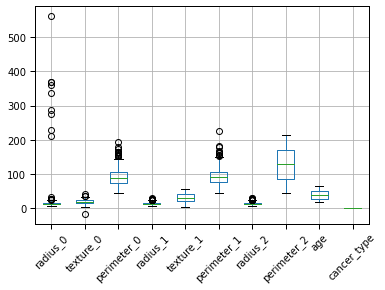

In [251]:
boxplot = train.boxplot(grid=True, rot=45, fontsize=10)

`Radius_0` has lot of outliers
`perimeter_0` and `perimeter_1` also contain significant outliers.

<hr>

#### 3.4 Calculate new feature "time_diff" between treatment_date and diagnose_date and drop  date columns

In [252]:
train['time_diff'] = (train['treatment_date'] - train['diagnose_date']).dt.days
train.drop(labels=['treatment_date', 'diagnose_date'], axis=1, inplace=True)

test['time_diff'] = (test['treatment_date'] - test['diagnose_date']).dt.days
test.drop(labels=['treatment_date', 'diagnose_date'], axis=1, inplace=True)

- `texture_2` column should be numeric and the missing values that are coded like xx.This has been corrected as follows

In [253]:
train['texture_2'] = pd.to_numeric(train['texture_2'], errors='coerce')
test['texture_2'] = pd.to_numeric(test['texture_2'], errors='coerce')

#### 3.5 Data Description

In [254]:
train.describe()

radius_0   texture_0  perimeter_0    radius_1   texture_1  \
count  398.000000  398.000000   398.000000  343.000000  398.000000   
mean    21.303711   18.957554    92.128890   14.123575   30.417222   
std     49.987646    6.243499    25.159787    3.780636   15.027855   
min      6.401956  -17.243202    45.612505    5.752395    2.395868   
25%     11.693885   14.581364    74.975361   11.600838   19.898062   
50%     13.468170   18.238742    87.376764   13.385789   30.897762   
75%     16.323024   22.494291   104.876420   16.051640   42.555657   
max    561.311068   40.064462   193.755763   29.645166   55.820612   

       perimeter_1    radius_2   texture_2  perimeter_2         age  \
count   264.000000  398.000000  382.000000   398.000000  398.000000   
mean     94.086379   14.134922   19.459098   127.222422   39.876884   
std      27.314466    3.748146    5.802189    49.097558   13.427196   
min      43.444930    7.079847   -0.966998    44.918942   18.000000   
25%      75.188880   11.573592   15.456557    84.123724   28.000000   
50%      90.054613   13.333610   19.436094   129.992697   39.000000   
75%     106.085670   16.093900   22.944174   169.538170   50.000000   
max     227.162938   28.563252   39.331864   214.192377   64.000000   

       cancer_type    time_diff  
count   398.000000   398.000000  
mean      0.628141  -198.015075  
std       0.483909  1055.455741  
min       0.000000 -2694.000000  
25%       0.000000 -1032.000000  
50%       1.000000  -244.500000  
75%       1.000000   597.750000  
max       1.000000  2081.000000

#### 3.6 Turn all negative entries to positive

Interestingly `texture_0`, `texture_1` are negative values! What is more puzzling is the time difference for some example s are negative which translates to the fact that the __patient was treated before the diagnosed!__ Quite unclear. Anyways this columns entries are converted to their abs values in order to bypas this discrepency.

In [255]:
train['texture_0'] = train['texture_0'].abs()
train['texture_2'] = train['texture_2'].abs()
train['time_diff'] = train['time_diff'].abs()

test['texture_0'] = test['texture_0'].abs()
test['texture_2'] = test['texture_2'].abs()
test['time_diff'] = test['time_diff'].abs()

##  <hr>

Train data is not perfectly balanced, but not highly skewed.

Text(0.5, 1.0, 'Count Plot of Target')

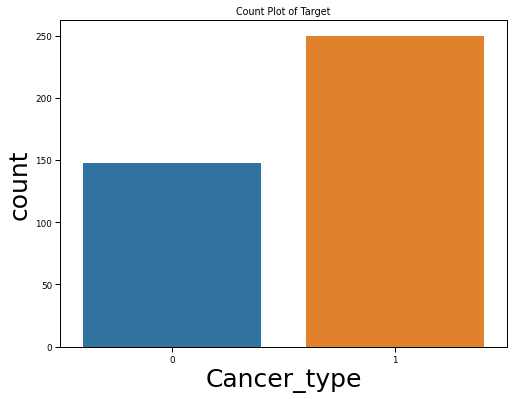

In [256]:
plt.figure(figsize=(8, 6))
_=sns.countplot(train['cancer_type'])
plt.xlabel("Cancer_type")
plt.title("Count Plot of Target")

#### 3.7 Parallel Coordinates plot
- Median imputated data before visualisations in order to avoid clipping ´.

In [257]:
train_pc = train
train_pc = train_pc.fillna(train_pc.median())

In [258]:
fig = px.parallel_coordinates(train_pc[['radius_0', 'texture_0',   
         'texture_2', 'perimeter_2', 'age','time_diff',
        'texture_1','perimeter_1','perimeter_0',
        'radius_1','radius_2', 'cancer_type']],color="cancer_type")
fig.show()

In [259]:
train_pc.loc[train_pc.radius_0 > 100, 'radius_0'] = np.median(train_pc.radius_0[train.radius_0<100])
train_pc = train_pc.fillna(train_pc.median())

In [260]:
fig = px.parallel_coordinates(train_pc[[ 'texture_0',   
         'texture_2', 'perimeter_2', 'age','time_diff',
        'texture_1','radius_0','perimeter_1','perimeter_0',
        'radius_1','radius_2', 'cancer_type']],color="cancer_type")
fig.show()

After removing outliers from radius_0 the relation hsip is much clear now. radius_0 is clearly distinguishes two cancer types.

<hr>

A pair plot draws pairwise relationships using scatter plots with histograms in the diagonal 
Points in the scatter plot are coloured with respect to the target so that it gives a clear idea about the data seperability.

#### 3.8 Pair plot

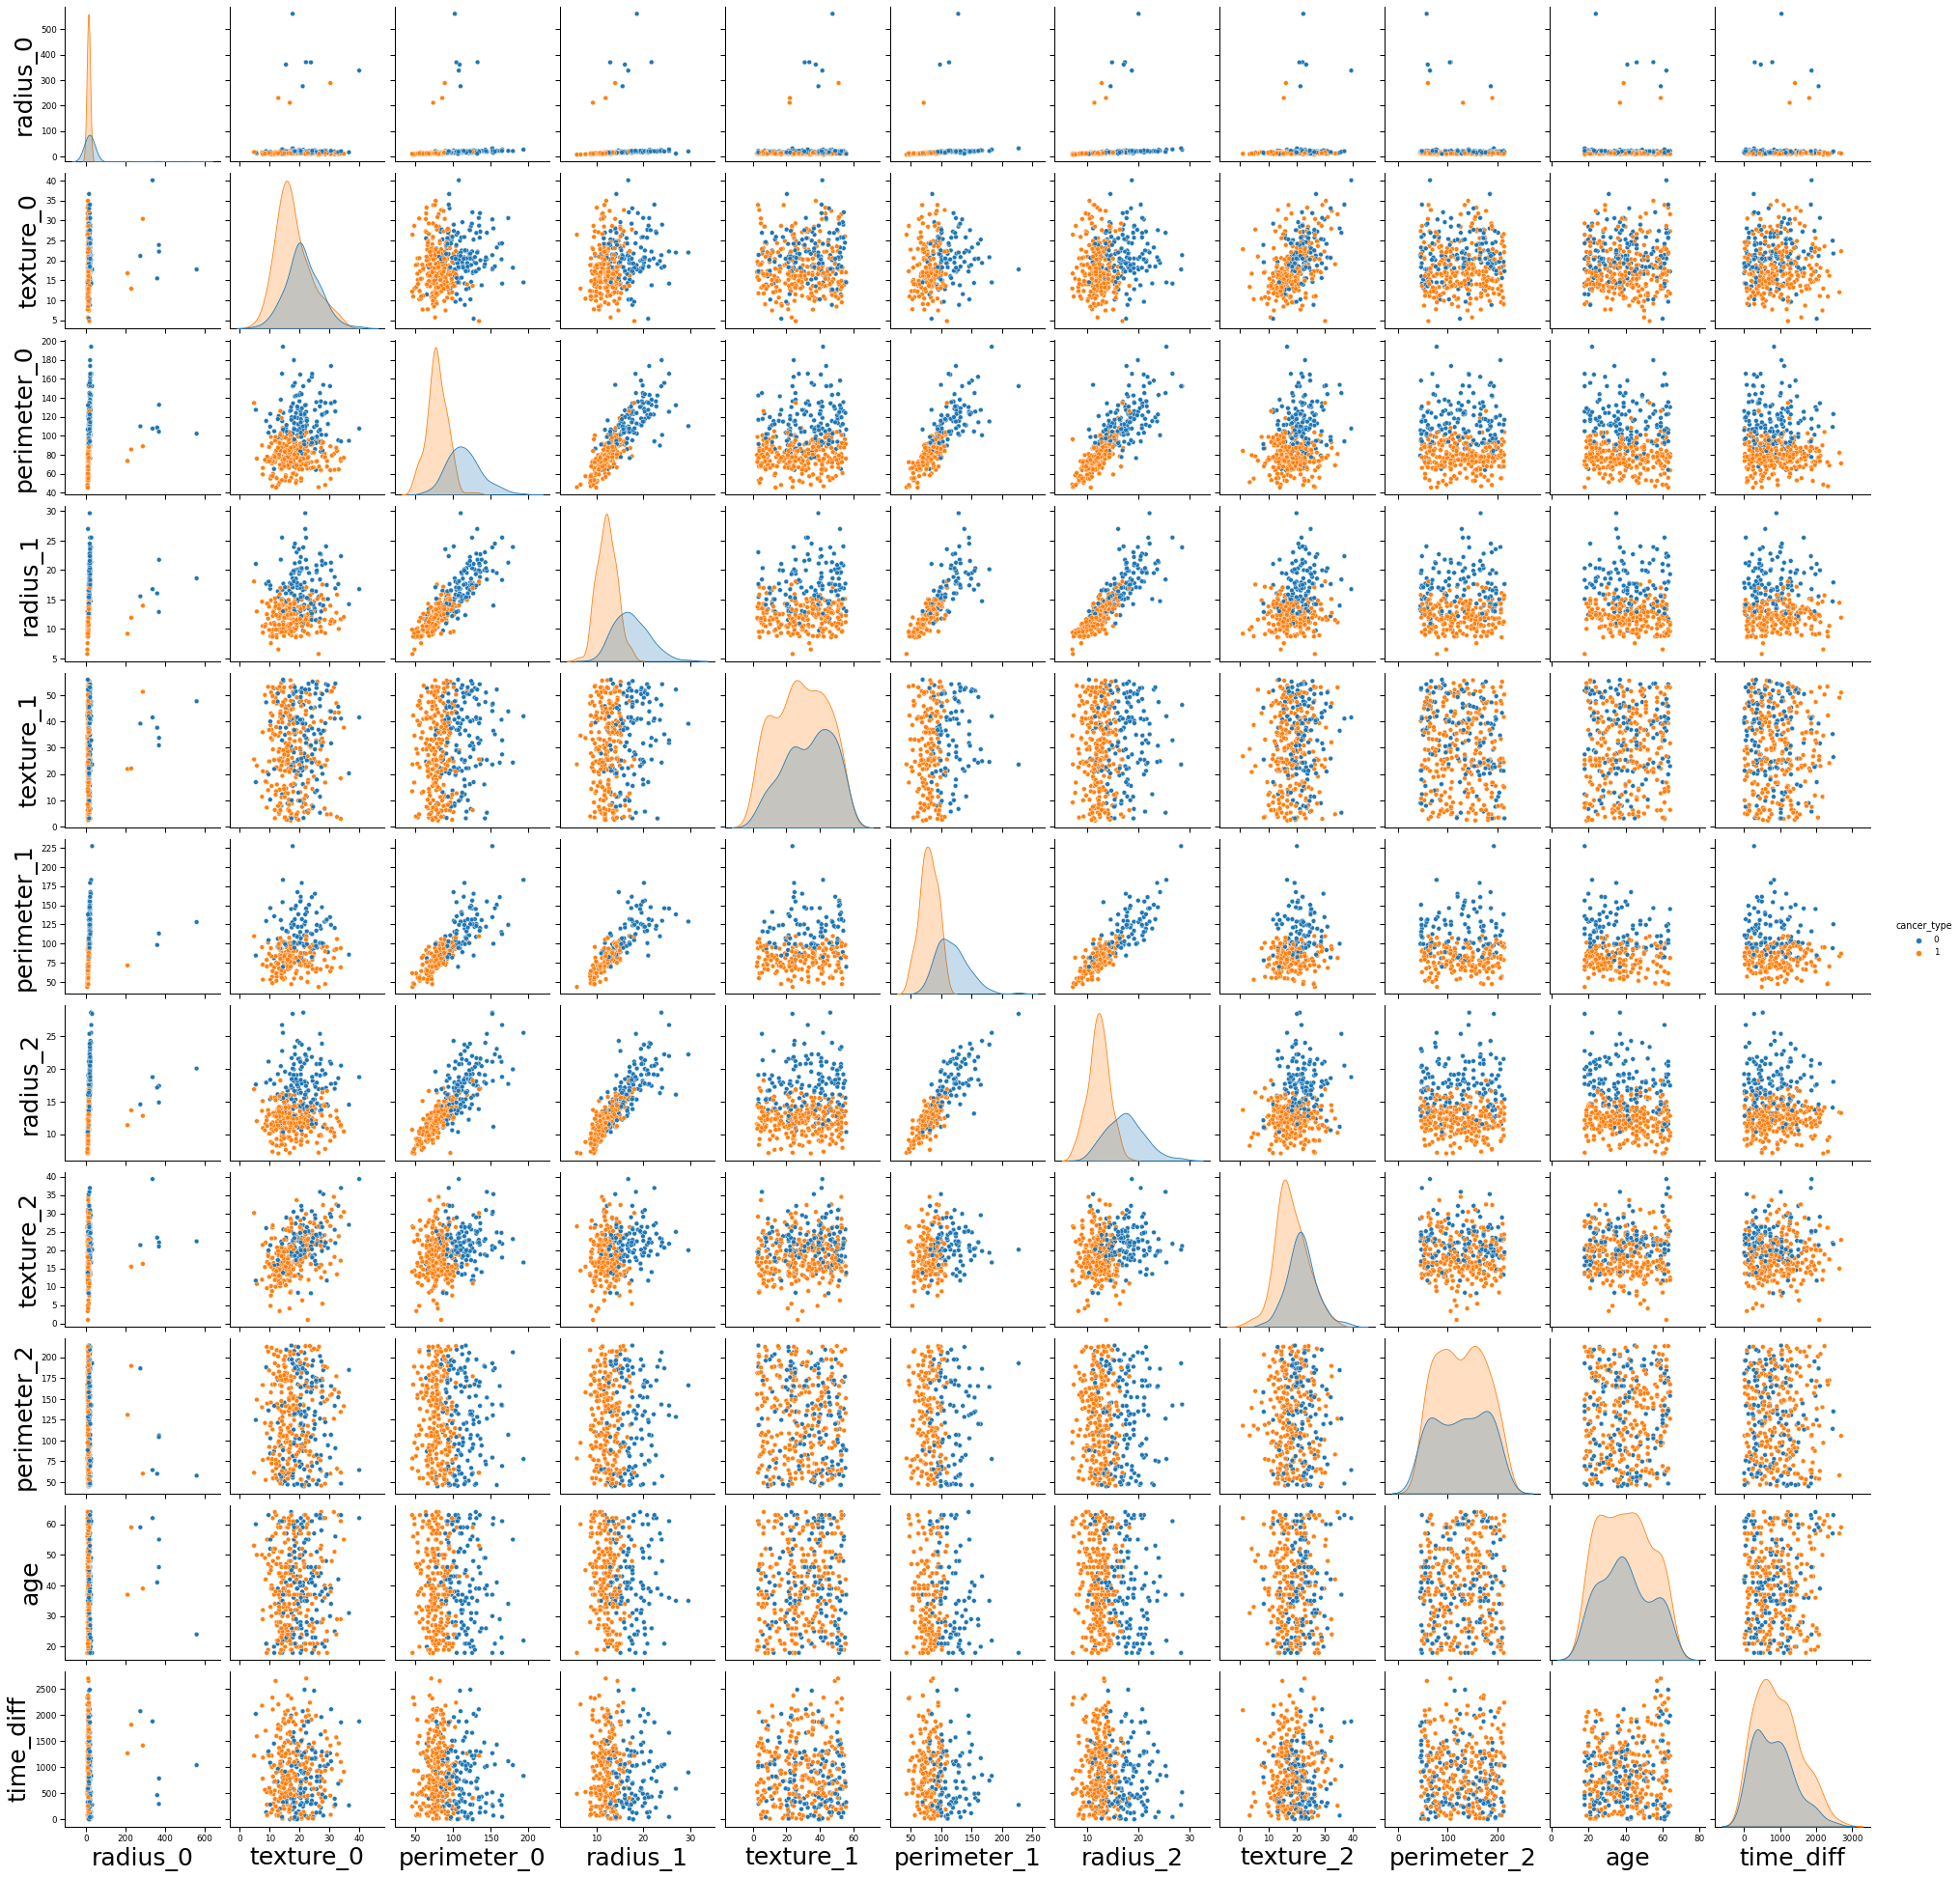

In [261]:
sns.set_context("paper", rc={"axes.labelsize":25})
sns.pairplot(train, hue='cancer_type')
plt.show()

Some takeaways from the above plot are: 
- Radius of the type_0 cell nuclei, 'radius_0' has big outliers.
- There are some distinct groupings of the pointsindicating thate there are some clusters in the data.

- radius_1 or perimeter_1 are important features to distinguish different cancer types. Higher end of these variables are mostly to belong to type_1 and vice versa.

- High positive covariance is is visible between some of the variables such as perimeter_0 and radius_2; radius_1 and radius_2. 
- Combination of Age and Radius, texture, perimeter features show a clear indication of dependency with cancer type


#### 3.9 Pearson’s Correlation: strength of the linear relationship between two feats.

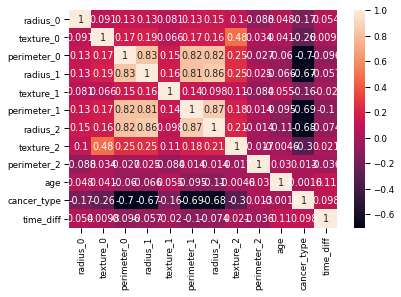

In [262]:
corr = train.corr(method = 'pearson')
sns.heatmap(corr, annot = True)
plt.show()

perimeter_0, radius_1, perimeter_1, radius_2 have strong correlations with each other. 
On the other side, negative correlation of these variables with the target variable is good.
age and timediff have some minor correlation.

# 4. Modelling

In [263]:
train_cols = train.columns
test_cols = test.columns

#### 4.1 Seperate X and y from train train data

In [264]:
train_y = train['cancer_type']
train_x = train.drop('cancer_type', axis=1)

#### 4.2  Impute missing values: trainset

In [265]:
imputer = IterativeImputer(random_state=44)
imputed = imputer.fit_transform(train_x)
train_x = pd.DataFrame(imputed, columns=train_x.columns)

#### 4.3 Impute missing values: testset

In [266]:
imputer = IterativeImputer(random_state=44)
imputed = imputer.fit_transform(test)
test = pd.DataFrame(imputed, columns=train_x.columns)

#### 4.4 Scaling train and test: strategy_1: standardscaler

In [267]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train_x)
# X_scaled = scaler.transform(train_x)
# test_scaled = scaler.transform(test)

In [268]:
# X_scaled = pd.DataFrame(X_scaled, columns = test.columns)
# X_scaled = X_scaled.drop(columns=['age', 'time_diff'])
# test_scaled = pd.DataFrame(test_scaled, columns = test.columns)

#### 4.4.1 Scaling train and test: strategy_2: Quantiletransformer

In [269]:
scaler = QuantileTransformer(output_distribution='normal')
scaler.fit(train_x)

QuantileTransformer(output_distribution='normal', 
                    random_state=None,
                    subsample=100)

X_scaled = scaler.transform(train_x)
test_scaled = scaler.transform(test)

In [270]:
# X_scaled = pd.DataFrame(X_scaled, columns = test.columns)
# test_scaled = pd.DataFrame(test_scaled, columns = test.columns)

#### Visualise scaled data

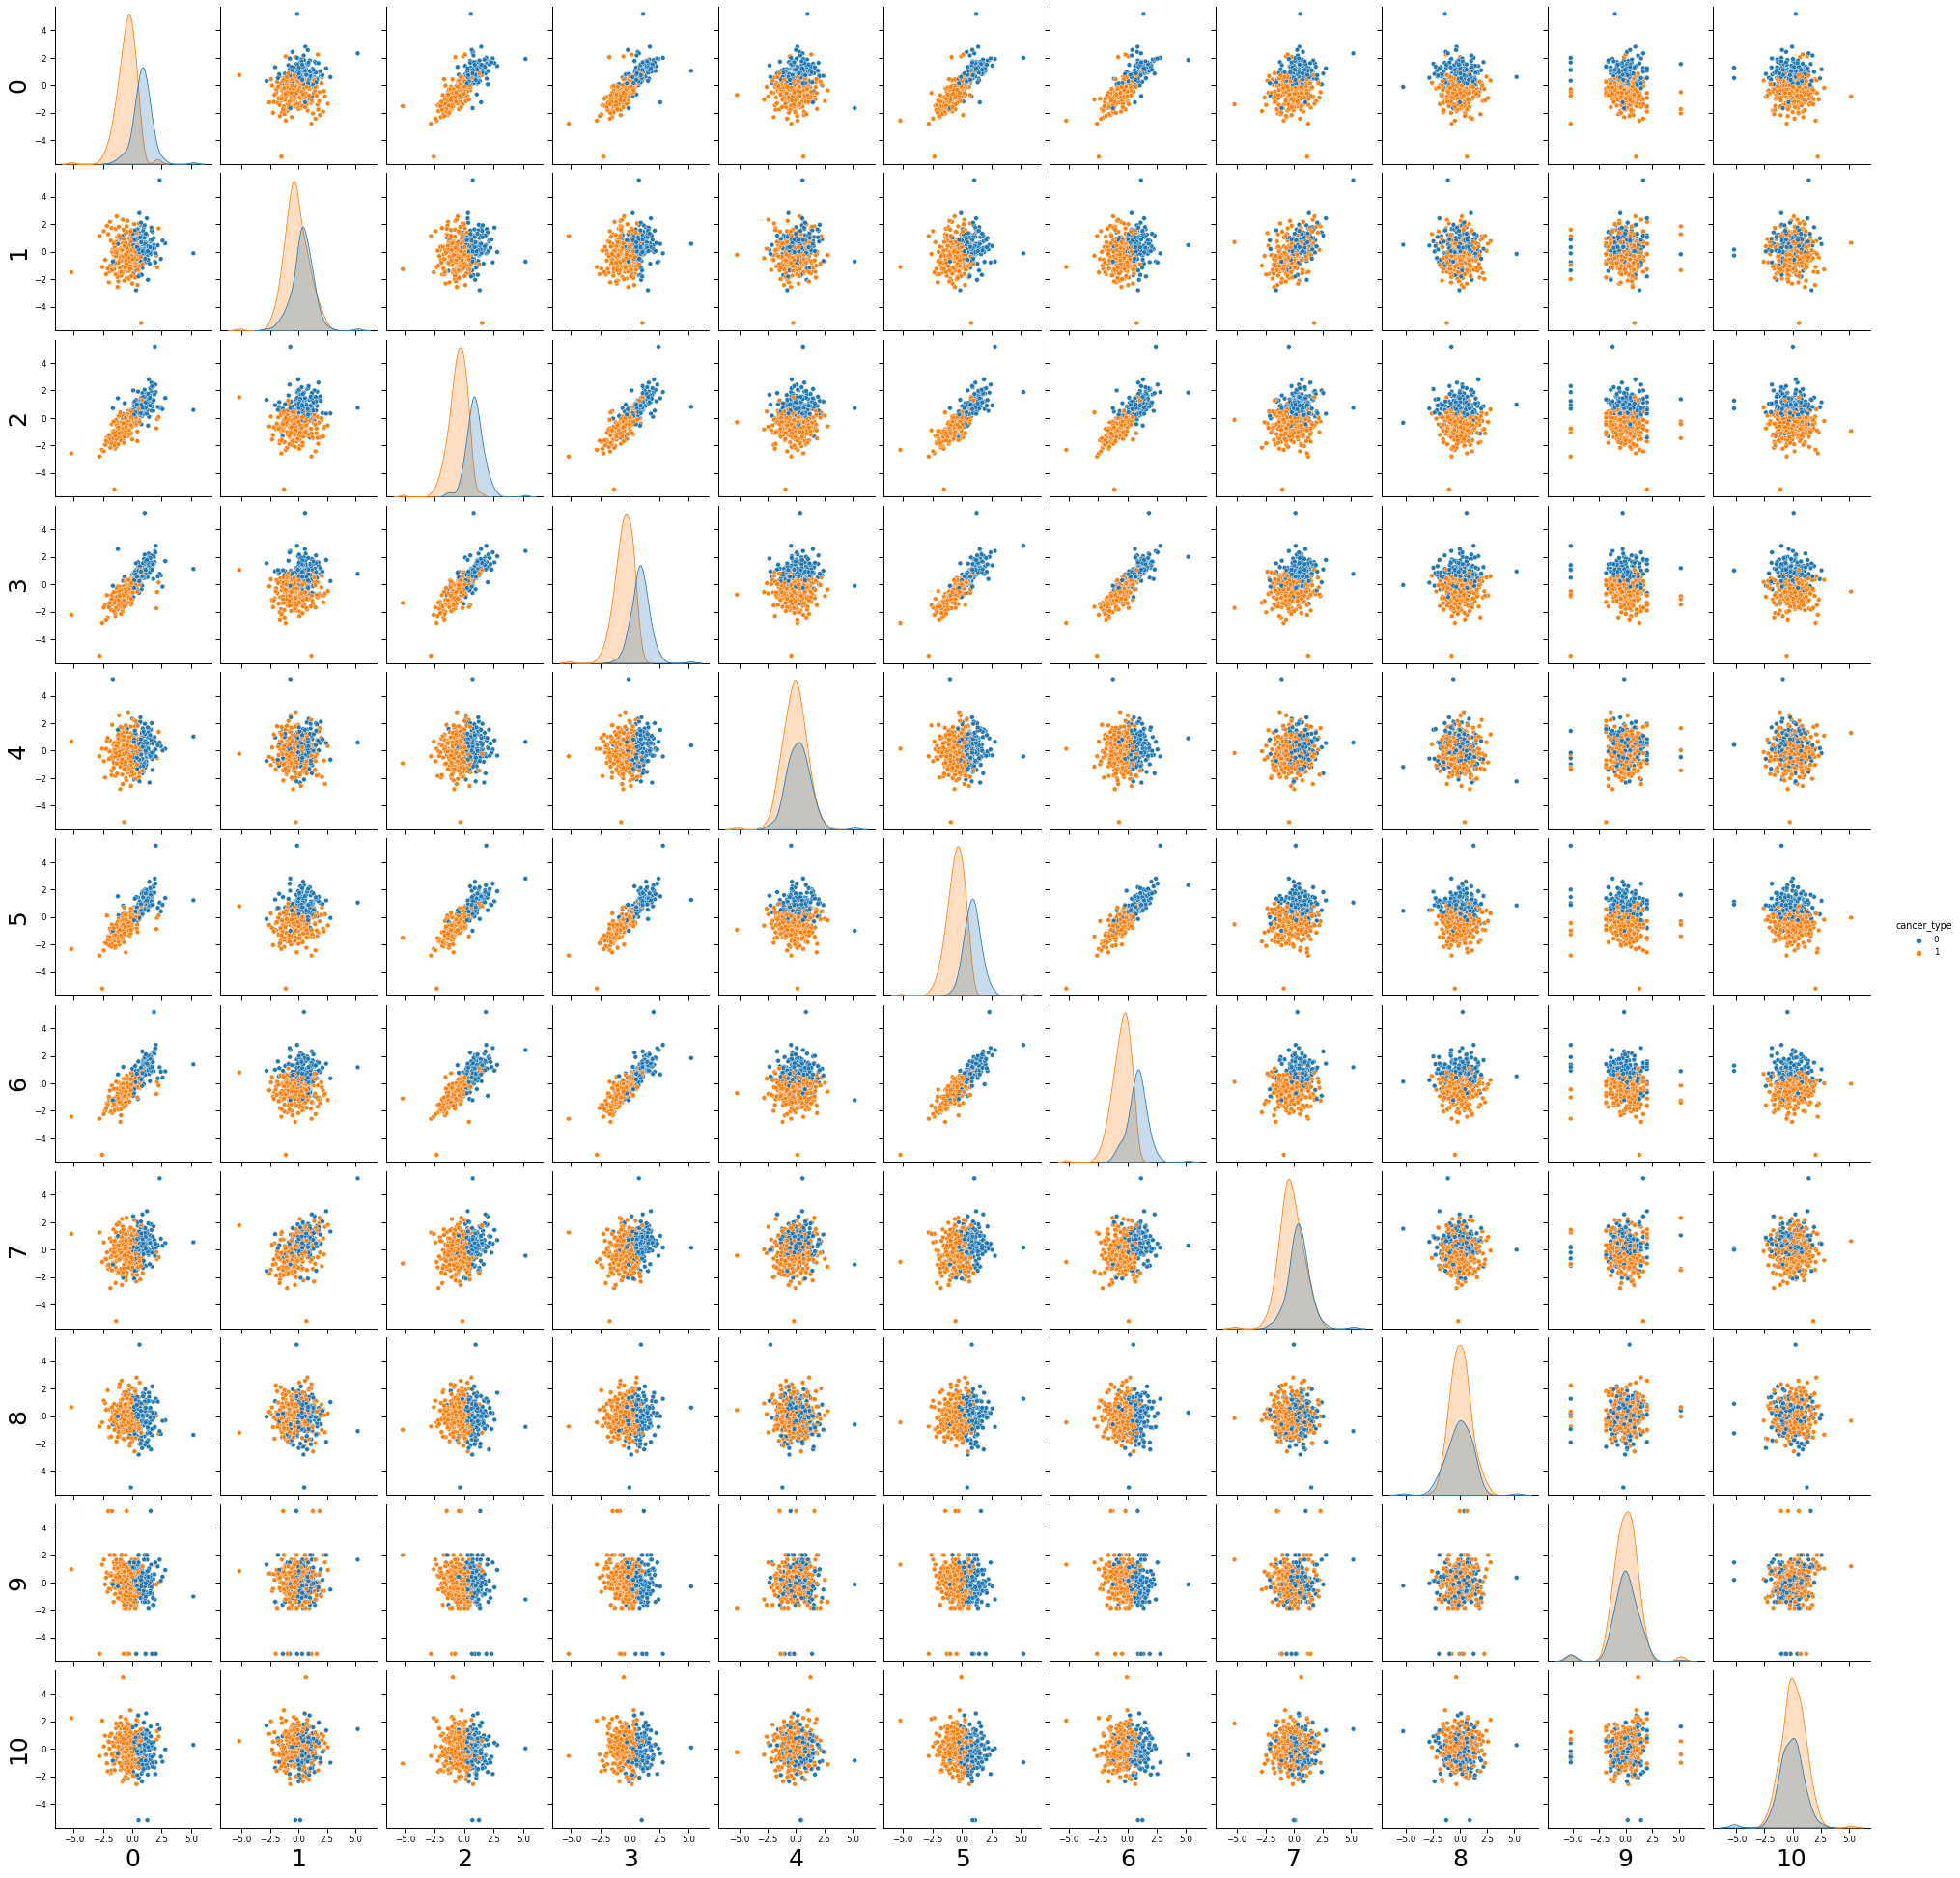

In [271]:
pp_df = pd.DataFrame(X_scaled)
pp_df["cancer_type"] = train_y
sns.set_context("paper", rc={"axes.labelsize":25})
sns.pairplot(pp_df, hue='cancer_type')
plt.show()

#### 4.5 Split train data for modelling

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, train_y, test_size=0.25, random_state=22, stratify=None)

In [273]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


# Base model
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, y_train, scoring='accuracy' ,cv=5).mean()
print("The mean accuracy with 10 fold cross validation is %s" % round(scores*100,2))

The mean accuracy with 10 fold cross validation is 90.23


## 4.6  Model : Logistic regression

In [274]:
log_reg_model = LogisticRegressionCV(class_weight='balanced', cv=3, solver='liblinear')

log_reg_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=8, class_weight='balanced', cv=3, max_iter=500,
           multi_class='ovr', n_jobs=1, random_state=None,
           solver='liblinear',
           verbose=1)


LogisticRegressionCV(Cs=8, class_weight='balanced', cv=3, max_iter=500,
                     multi_class='ovr', n_jobs=1, solver='liblinear',
                     verbose=1)

####  Predict on test

In [285]:
pred_y = log_reg_model.predict(X_test)
cf_matrix = metrics.confusion_matrix(y_test, pred_y)

#### Visualise confusion matrix

<AxesSubplot:>

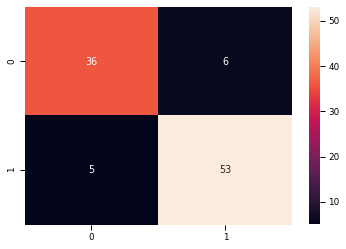

In [276]:
plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, annot=True )

#### Print report

In [277]:
print(metrics.classification_report(y_test, pred_y, 
                                    labels=None, target_names=['cancer_type_0', 'cancer_type_1'], 
                                    sample_weight=None, digits=2))

               precision    recall  f1-score   support

cancer_type_0       0.88      0.86      0.87        42
cancer_type_1       0.90      0.91      0.91        58

     accuracy                           0.89       100
    macro avg       0.89      0.89      0.89       100
 weighted avg       0.89      0.89      0.89       100



In [278]:
y_score_log = log_reg_model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test, y_score_log)

In [279]:
average_precision_log = average_precision_score(y_test, y_score_log)
print('Mean precision-recall: {0:0.2f}'.format(average_precision_log))

Mean precision-recall: 0.92


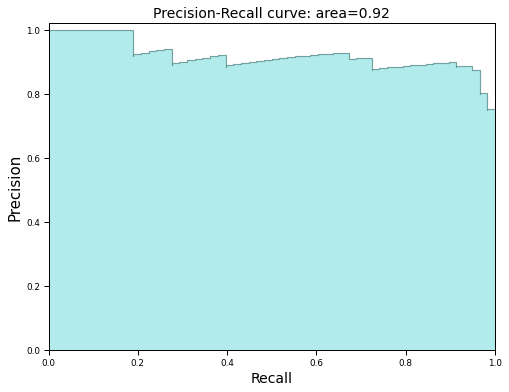

In [280]:
_ = plt.figure(figsize=(8,6),linewidth=4)

_ = plt.step(recall, precision, color='k', alpha=0.3,where='post')
_ = plt.fill_between(recall, precision, step='post', alpha=0.3,color='c')

_ = plt.xlabel('Recall', fontsize=14)
_ = plt.ylabel('Precision', fontsize=15)
_ = plt.ylim([0.0, 1.02])
_ = plt.xlim([0.0, 1.0])
_ = plt.title('Precision-Recall curve: area={0:0.2f}'.format(average_precision_log), fontsize=14)

In [281]:
fpr, tpr, thresholds = roc_curve(y_test, y_score_log)

In [282]:
roc_auc = roc_auc_score(y_test, y_score_log)


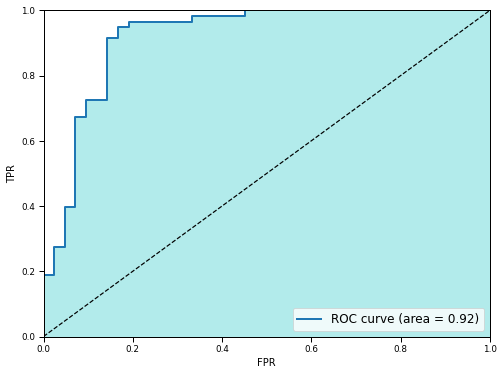

In [283]:
def plot_roc_curve(fpr, tpr, **options):
    plt.plot(fpr, tpr, linewidth=2, **options)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.fill_between(fpr, tpr, step='post', alpha=0.3,
                 color='c')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=10)
    plt.ylabel('TPR', fontsize=10)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right", fontsize=12)
plt.show()

- `age`: seems uncorrelated to the cancer type, perhaps some combination with `diagnosis`or `treatment` is?
- `texture`: Less associated with cancer types
- `nucleii 0`: seems most associated with cancer types

In [284]:
pred_test = log_reg_model.predict(test_scaled)

1. Feature engineering
2. try diferent modelling, grid search etc,..